# Testing out new kde-based method!
> so many bins :)

![](assets/kde_interesting.gif)

In [ ]:
import jax
import neos.makers as makers
import neos.cls as cls
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())

In [ ]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid 
)

In [ ]:
bins = np.linspace(0,1,6)
centers   = bins[:-1]  + np.diff(bins)/2.
bandwidth = .4 * 1/(len(bins)-1)

hmaker = makers.kde_bins_from_nn_three_blobs(predict,bins=bins,bandwidth=bandwidth)
nnm = makers.nn_hepdata_like(hmaker)
loss = cls.cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))
bandwidth

0.08

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
gradd = jax.jit(jax.value_and_grad(loss))
_, network = init_random_params(jax.random.PRNGKey(13), (-1, 2))
gradd(network, 1.0)

(DeviceArray(0.05880111, dtype=float64),
 [(DeviceArray([[-0.00179044, -0.00056627,  0.00202215, ..., -0.00396901,
                 -0.00175673, -0.00723417],
                [-0.00017432, -0.00024473, -0.00143037, ..., -0.00237224,
                 -0.00317624, -0.00390435]], dtype=float32),
   DeviceArray([ 0.00124554, -0.00019967, -0.00139115, ..., -0.00029852,
                -0.00180919, -0.00188678], dtype=float32)),
  (),
  (DeviceArray([[-2.70764849e-05, -6.28665646e-07, -1.20917028e-08, ...,
                  4.85653118e-06, -8.11458813e-05,  3.06508809e-05],
                [ 2.83182326e-05,  3.31130068e-05,  4.30183434e-07, ...,
                  0.00000000e+00,  1.55358535e-07, -2.02215233e-07],
                [-1.45628455e-05, -2.74914839e-07, -5.74184167e-09, ...,
                  2.39836436e-06, -6.88106229e-05,  3.14157187e-05],
                ...,
                [-3.00191073e-06,  7.77033274e-05,  9.19293257e-07, ...,
                  1.99842589e-06, -2.74845777e-

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(3e-3)

#@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="jet",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    nn = s, b, db = hm(network)
    bin_width = 1/(len(bins)-1)
    ax.bar(centers, b, color="C1", label="bkg",width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", label="sig",width=bin_width)
    ax.bar(centers, db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error",width=bin_width)
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

## Install celluloid for animations!

In [ ]:
!python -m pip install celluloid

### Let's run it!!

epoch 0: CLs = 0.061524204700417195, took 7.181300163269043s
epoch 1: CLs = 0.038272014302923596, took 1.3694071769714355s
epoch 2: CLs = 0.0038476321388671852, took 1.3954288959503174s
epoch 3: CLs = 0.04351751517576652, took 1.365785837173462s
epoch 4: CLs = 0.006314677268905777, took 1.3489091396331787s
epoch 5: CLs = 0.0019261697248236231, took 1.3820810317993164s
epoch 6: CLs = 0.0028004005358872597, took 1.3562629222869873s
epoch 7: CLs = 0.002297108891974986, took 1.3525168895721436s
epoch 8: CLs = 0.010675734361591749, took 1.348271131515503s
epoch 9: CLs = 0.01199155502521454, took 1.3472709655761719s
epoch 10: CLs = 0.00762593726609162, took 1.3535170555114746s
epoch 11: CLs = 0.0032174685672372583, took 1.370344877243042s
epoch 12: CLs = 0.001166807205252418, took 1.3701229095458984s
epoch 13: CLs = 0.0004404550097800719, took 1.3815929889678955s
epoch 14: CLs = 0.0004199528500352656, took 1.3516571521759033s
epoch 15: CLs = 0.00043441462951632204, took 1.3560807704925537s
e

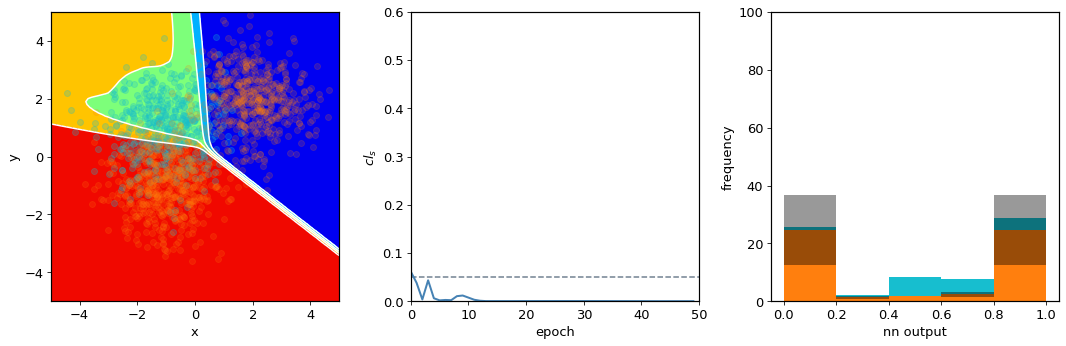

In [ ]:
#slow
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13., 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 50 # make me bigger for better results!

animate = False # animations fail tests...

if animate:
    from celluloid import Camera
    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            #HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)